In [1]:
import pandas as pd
import numpy as np
import seaborn as sns             #visualisation
import matplotlib.pyplot as plt   #visualisation
import os

%matplotlib inline 
sns.set(color_codes=True)

from dotenv import load_dotenv
from core_ds4a_project import cleaning, columns as project_columns, datasets

%load_ext autoreload
%autoreload 1
%aimport core_ds4a_project, core_ds4a_project.cleaning, core_ds4a_project.columns, core_ds4a_project.datasets

pd.set_option("display.max_columns", None)

In [2]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split

In [3]:
load_dotenv('envvars')

ROOT_DATA_PATH = os.environ.get('ROOT_DATA_PATH')
RAW_DATA_PATH = os.environ.get('RAW_DATA_PATH') or f'{ROOT_DATA_PATH}/raw'

In [4]:
(cartera_df, clientes_df, colocacion_df) = datasets.read_joining_datasets(dir_path=RAW_DATA_PATH)

In [5]:
cartera_df = cartera_df.sort_values(['FECHA_CIERRE', 'OBLIGACION'], ascending=True)
ind_first = ~(cartera_df.duplicated(keep='first', subset='OBLIGACION'))
ind_last = ~(cartera_df.duplicated(keep='last', subset='OBLIGACION'))

In [6]:
lasts_records_cartera_df = cartera_df[ind_last].copy()
lasts_records_cartera_df.shape

(38641, 32)

In [7]:
lasts_records_cartera_df.head(5)

,OBLIGACION,CLIENTE,TIPO_CLIENTE_COD,TIPO_CLIENTE,SUCURSAL_REAL,REGION,MUNICIPIO_CLIENTE,VALOR_CUOTA,CUOTAS_PACTADAS,CUOTAS_PENDIENTES,TASA_PERIODICA,PERIODICIDAD_PAGO,CALIFICACION_CIERRE,MODALIDAD,SALDO,VENCIDA,DIAS_VENCIDO,CAPITAL_VEN,INTERES_VEN,MORA,SEGURO_VIDA,COMISION,OTROS,FECHA_ULT_PAGO,FECHA_PROXIMO_PAGO,FECHA_VENCIMIENTO_FINAL,PORCENTAJE_PAGO,TIPO_CREDITO,SUCURSAL_COD,FECHA_CIERRE,MUNICIPIO_LAT,MUNICIPIO_LON
69783,171000008,FA12448,1.0,Microfinanciero,MONTERREY,REGION SUR,SABANALARGA,197638,12,12,2.64,Mensual,A,CREDITO RURAL INDIVIDUAL - GERMINA,2000000,-,0,-,-,-,-,0,0,2017-01-20,2017-02-19,2018-01-19,100.0,NUEVO,NaN,2017-01-31,4.85430,-73.04003
69598,172000006,FA25175,1.0,Microfinanciero,VILLAVICENCIO,REGION VILLAVICENCIO,VILLAVICENCIO,293974,36,36,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),6000000,-,0,-,-,-,-,0,0,NaT,2017-02-19,2020-01-19,100.0,RETANQUEADO,NaN,2017-01-31,4.14200,-73.62664
69674,173000013,FA23399,1.0,Microfinanciero,ACACIAS,REGION META,ACACIAS,183032,24,24,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),2950000,-,0,-,-,-,-,0,0,NaT,2017-02-27,2019-01-27,100.0,NUEVO,NaN,2017-01-31,3.98695,-73.75797
69746,176000015,FA19928,1.0,Microfinanciero,GRANADA,REGION META,GRANADA,179930,24,24,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),2900000,-,0,-,-,-,-,0,0,NaT,2017-02-28,2019-01-31,100.0,NUEVO,NaN,2017-01-31,3.54625,-73.70687
69702,177000008,FA227,1.0,Microfinanciero,MONTERREY,REGION SUR,MONTERREY,103305,12,12,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),1000000,-,0,-,-,-,-,0,0,NaT,2017-02-28,2018-01-31,100.0,NUEVO,NaN,2017-01-31,4.87802,-72.89575


In [8]:
idx = lasts_records_cartera_df['CALIFICACION_CIERRE'] != 'A'
len(lasts_records_cartera_df[idx]), len(lasts_records_cartera_df[idx]['CLIENTE'].unique())

(5620, 5487)

In [9]:
model1_df = pd.merge(lasts_records_cartera_df, colocacion_df, how='left', on="OBLIGACION", suffixes=('_left', '_right'))
model1_df.shape

(38641, 57)

In [10]:
model1_df = model1_df.rename(columns={'CLIENTE_left':'CLIENTE',
                                      'VALOR_CUOTA_left':'VALOR_CUOTA'
                                     })

In [11]:
model_df = pd.merge(model1_df, clientes_df, how='left', on="CLIENTE", suffixes=('_left_model', '_right_client'))
model_df.shape

(38641, 83)

In [12]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38641 entries, 0 to 38640
Data columns (total 83 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   OBLIGACION               38641 non-null  int64         
 1   CLIENTE                  38641 non-null  object        
 2   TIPO_CLIENTE_COD         38641 non-null  float64       
 3   TIPO_CLIENTE             38641 non-null  object        
 4   SUCURSAL_REAL            38629 non-null  object        
 5   REGION                   38641 non-null  object        
 6   MUNICIPIO_CLIENTE        38641 non-null  object        
 7   VALOR_CUOTA              38641 non-null  object        
 8   CUOTAS_PACTADAS          38641 non-null  int64         
 9   CUOTAS_PENDIENTES        38641 non-null  int64         
 10  TASA_PERIODICA           38641 non-null  float64       
 11  PERIODICIDAD_PAGO_left   38641 non-null  category      
 12  CALIFICACION_CIERRE      38641 n

In [13]:
model_df['DEFAULT'].unique()

array([nan, True], dtype=object)

In [14]:
idx = model_df["DEFAULT"] != True
model_df.loc[idx,'DEFAULT'] = 0

In [15]:
idx = model_df["DEFAULT"] == True
model_df.loc[idx,'DEFAULT'] = 1

In [16]:
model_df['DEFAULT'] = model_df['DEFAULT'].astype('int64')

In [17]:
model_df['DEFAULT'].unique()

array([0, 1])

In [18]:
num_to_cat = ['MUNICIPIO_CLIENTE', 'MUJER_CABEZA', 'RESPONSABLE_DE_HOGAR', 'OCUPACION', 'ESTADO_CIVIL_COD', 'GENERO_COD', 
              'NIVEL_ESTUDIOS_COD', 'TIPO_VIVIENDA', 'ESTRATO']
model_df[num_to_cat] = model_df[num_to_cat].astype('object')

In [19]:
numeric_cols = model_df.select_dtypes(include = np.number).columns.tolist()
numeric_cols

['OBLIGACION',
 'TIPO_CLIENTE_COD',
 'CUOTAS_PACTADAS',
 'CUOTAS_PENDIENTES',
 'TASA_PERIODICA',
 'SALDO',
 'DIAS_VENCIDO',
 'PORCENTAJE_PAGO',
 'MUNICIPIO_LAT',
 'MUNICIPIO_LON',
 'TASA_ANUAL',
 'MONTO',
 'VALOR_REFINANCIADO',
 'VALOR_DESEMBOLSADO',
 'NRO_CUOTAS',
 'CREDITOS_VIGENTES',
 'DEFAULT',
 'EDAD',
 'SUELDO_BASICO']

In [26]:
num_selected = ['TASA_ANUAL',
 'MONTO',
 'NRO_CUOTAS',
 'EDAD'
]

In [27]:
categorical_cols2 = model_df.select_dtypes('category').columns.tolist()
model_df[categorical_cols2]=model_df[categorical_cols2].astype('object')

In [28]:
categorical_cols = model_df.select_dtypes('object').columns.tolist()
categorical_cols

['CLIENTE',
 'TIPO_CLIENTE',
 'SUCURSAL_REAL',
 'REGION',
 'MUNICIPIO_CLIENTE',
 'VALOR_CUOTA',
 'PERIODICIDAD_PAGO_left',
 'CALIFICACION_CIERRE',
 'MODALIDAD_left',
 'VENCIDA',
 'CAPITAL_VEN',
 'INTERES_VEN',
 'MORA',
 'SEGURO_VIDA',
 'COMISION',
 'OTROS',
 'TIPO_CREDITO_left',
 'SUCURSAL_COD',
 'COD_LINEA',
 'LINEA',
 'COD_DESTINACION',
 'DESTINACION',
 'OBSERVACIONES',
 'VALOR_CUOTA_right',
 'PERIODICIDAD_PAGO_right',
 'COD_MODALIDAD',
 'MODALIDAD_right',
 'ANO_CONTABILIZA',
 'CODEUDOR',
 'DIAS_CICLO_CREDITO',
 'TIPO_CREDITO_right',
 'CLIENTE_right',
 'ESTRATO',
 'SUCURSAL',
 'TIPO_DE_CLIENTE',
 'ACTIVIDAD_ECONOMICA',
 'TIPO_DE_IDENTIFICACION',
 'OFICIO',
 'MUJER_CABEZA',
 'RESPONSABLE_DE_HOGAR',
 'OCUPACION',
 'ACTIVIDAD_CIIU_PRIMARIA',
 'ESTADO_CIVIL_COD',
 'GENERO_COD',
 'NIVEL_ESTUDIOS_COD',
 'PROFESION_COD',
 'TIPO_UBICACION_COD',
 'TIPO_VIVIENDA_COD',
 'PROFESION',
 'TIPO_UBICACION',
 'GENERO',
 'NIVEL_ESTUDIOS',
 'ESTADO_CIVIL',
 'TIPO_VIVIENDA',
 'ACTIVIDAD']

In [29]:
model_df[categorical_cols] = model_df[categorical_cols].astype('str')

In [30]:
from sklearn.impute import SimpleImputer

In [31]:
imputer = SimpleImputer(strategy = 'mean').fit(model_df[num_selected])
model_df[num_selected] = imputer.transform(model_df[num_selected])

In [32]:
model_df[num_selected]

,TASA_ANUAL,MONTO,NRO_CUOTAS,EDAD
0,31.67,2000000.0,12.0,51.0
1,35.29,6000000.0,36.0,48.0
2,35.29,2950000.0,24.0,53.0
3,35.29,2900000.0,24.0,50.0
4,35.29,1000000.0,12.0,73.0
...,...,...,...,...
38636,35.28,1000000.0,1.0,54.0
38637,38.40,6000000.0,24.0,34.0
38638,35.28,1000000.0,1.0,50.0
38639,31.68,4000000.0,6.0,28.0


In [33]:
model_df[num_selected].isna().sum()

TASA_ANUAL    0
MONTO         0
NRO_CUOTAS    0
EDAD          0
dtype: int64

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [35]:
model_df.describe().loc[['min','max']]

,OBLIGACION,TIPO_CLIENTE_COD,CUOTAS_PACTADAS,CUOTAS_PENDIENTES,TASA_PERIODICA,SALDO,DIAS_VENCIDO,PORCENTAJE_PAGO,MUNICIPIO_LAT,MUNICIPIO_LON,TASA_ANUAL,MONTO,VALOR_REFINANCIADO,VALOR_DESEMBOLSADO,NRO_CUOTAS,CREDITOS_VIGENTES,DEFAULT,EDAD,SUELDO_BASICO
min,1.710000e+08,1.0,1.0,0.0,1.00,1.0,0.0,0.0,2.77411,-74.02335,12.0,300000.0,0.0,0.0,1.0,1.0,0.0,19.0,0.0
max,2.112000e+09,7.0,72.0,72.0,12.29,64772960.0,1048.0,100.0,6.46065,-71.33917,39.6,80000000.0,20000000.0,78851467.0,72.0,3.0,1.0,78.0,84000000.0


In [36]:
scaler = MinMaxScaler().fit(model_df[numeric_cols])
model_df[numeric_cols] = scaler.transform(model_df[numeric_cols])
model_df.describe().loc[['min','max']]

,OBLIGACION,TIPO_CLIENTE_COD,CUOTAS_PACTADAS,CUOTAS_PENDIENTES,TASA_PERIODICA,SALDO,DIAS_VENCIDO,PORCENTAJE_PAGO,MUNICIPIO_LAT,MUNICIPIO_LON,TASA_ANUAL,MONTO,VALOR_REFINANCIADO,VALOR_DESEMBOLSADO,NRO_CUOTAS,CREDITOS_VIGENTES,DEFAULT,EDAD,SUELDO_BASICO
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [37]:
model_df[categorical_cols].nunique()

CLIENTE                    22965
TIPO_CLIENTE                   6
SUCURSAL_REAL                 16
REGION                        15
MUNICIPIO_CLIENTE             74
VALOR_CUOTA                 8147
PERIODICIDAD_PAGO_left         4
CALIFICACION_CIERRE            5
MODALIDAD_left                34
VENCIDA                     4754
CAPITAL_VEN                19136
INTERES_VEN                19463
MORA                        8516
SEGURO_VIDA                 5035
COMISION                    7260
OTROS                          4
TIPO_CREDITO_left              5
SUCURSAL_COD                  15
COD_LINEA                      8
LINEA                          8
COD_DESTINACION                9
DESTINACION                    9
OBSERVACIONES              37869
VALOR_CUOTA_right           6217
PERIODICIDAD_PAGO_right        4
COD_MODALIDAD                 31
MODALIDAD_right               31
ANO_CONTABILIZA                6
CODEUDOR                       6
DIAS_CICLO_CREDITO            32
TIPO_CREDI

In [ ]:
categorical_cols

In [45]:
cat_selected = [ 'TIPO_CLIENTE',
 'MUNICIPIO_CLIENTE',
 #'PERIODICIDAD_PAGO_left',
 'TIPO_CREDITO_left',
 #'SUCURSAL_COD',
 #'COD_LINEA',
 #'COD_DESTINACION',
 #'COD_MODALIDAD',
 'CODEUDOR',
 #'ACTIVIDAD_ECONOMICA',
 'MUJER_CABEZA',
 'RESPONSABLE_DE_HOGAR',
 #'ESTADO_CIVIL_COD',
 'GENERO_COD',
 'NIVEL_ESTUDIOS_COD',
 #'PROFESION_COD',
 'TIPO_UBICACION_COD',
 #'TIPO_VIVIENDA_COD'
               ]

In [46]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(model_df[cat_selected])
encoded_cols = list(encoder.get_feature_names_out(cat_selected))

In [47]:
model_df[encoded_cols] = encoder.transform(model_df[cat_selected]);
model_df.head()

,OBLIGACION,CLIENTE,TIPO_CLIENTE_COD,TIPO_CLIENTE,SUCURSAL_REAL,REGION,MUNICIPIO_CLIENTE,VALOR_CUOTA,CUOTAS_PACTADAS,CUOTAS_PENDIENTES,TASA_PERIODICA,PERIODICIDAD_PAGO_left,CALIFICACION_CIERRE,MODALIDAD_left,SALDO,VENCIDA,DIAS_VENCIDO,CAPITAL_VEN,INTERES_VEN,MORA,SEGURO_VIDA,COMISION,OTROS,FECHA_ULT_PAGO,FECHA_PROXIMO_PAGO,FECHA_VENCIMIENTO_FINAL,PORCENTAJE_PAGO,TIPO_CREDITO_left,SUCURSAL_COD,FECHA_CIERRE,MUNICIPIO_LAT,MUNICIPIO_LON,TASA_ANUAL,MONTO,VALOR_REFINANCIADO,VALOR_DESEMBOLSADO,FECHA_SOLICITUD,FECHA_APROBA,FECHA_DESEMBOLSO,COD_LINEA,LINEA,COD_DESTINACION,DESTINACION,OBSERVACIONES,VALOR_CUOTA_right,NRO_CUOTAS,FECHA_PAGO,PERIODICIDAD_PAGO_right,COD_MODALIDAD,MODALIDAD_right,ANO_CONTABILIZA,CODEUDOR,DIAS_CICLO_CREDITO,CREDITOS_VIGENTES,TIPO_CREDITO_right,CLIENTE_right,DEFAULT,EDAD,ESTRATO,SUCURSAL,TIPO_DE_CLIENTE,SUELDO_BASICO,ACTIVIDAD_ECONOMICA,TIPO_DE_IDENTIFICACION,OFICIO,MUJER_CABEZA,RESPONSABLE_DE_HOGAR,OCUPACION,ACTIVIDAD_CIIU_PRIMARIA,ESTADO_CIVIL_COD,GENERO_COD,NIVEL_ESTUDIOS_COD,PROFESION_COD,TIPO_UBICACION_COD,TIPO_VIVIENDA_COD,PROFESION,TIPO_UBICACION,FECHA_NACIMIENTO,GENERO,NIVEL_ESTUDIOS,ESTADO_CIVIL,TIPO_VIVIENDA,ACTIVIDAD,TIPO_CLIENTE_Codeudor no cliente,TIPO_CLIENTE_Fondeador,TIPO_CLIENTE_Gestion social,TIPO_CLIENTE_Microfinanciero,TIPO_CLIENTE_Mixto,TIPO_CLIENTE_Proveedor,MUNICIPIO_CLIENTE_ACACIAS,MUNICIPIO_CLIENTE_AGUAZUL,MUNICIPIO_CLIENTE_AQUITANIA,MUNICIPIO_CLIENTE_BARRANCA DE UPIA,MUNICIPIO_CLIENTE_BELEN,MUNICIPIO_CLIENTE_BUZBANZA,MUNICIPIO_CLIENTE_CASTILLA LA NUEVA,MUNICIPIO_CLIENTE_CASTILLO,MUNICIPIO_CLIENTE_CERINZA,MUNICIPIO_CLIENTE_CHAMEZA,MUNICIPIO_CLIENTE_COMBITA,MUNICIPIO_CLIENTE_CORRALES,MUNICIPIO_CLIENTE_CUITIVA,MUNICIPIO_CLIENTE_CUMARAL,MUNICIPIO_CLIENTE_DUITAMA,MUNICIPIO_CLIENTE_EL DORADO,MUNICIPIO_CLIENTE_FIRAVITOBA,MUNICIPIO_CLIENTE_FLORESTA,MUNICIPIO_CLIENTE_FUENTE DE ORO,MUNICIPIO_CLIENTE_GAMEZA,MUNICIPIO_CLIENTE_GRANADA,MUNICIPIO_CLIENTE_GUAMAL,MUNICIPIO_CLIENTE_GUAYABETAL,MUNICIPIO_CLIENTE_HATO COROZAL,MUNICIPIO_CLIENTE_IZA,MUNICIPIO_CLIENTE_LEJANIAS,MUNICIPIO_CLIENTE_MANI,MUNICIPIO_CLIENTE_MAYA,MUNICIPIO_CLIENTE_MEDINA,MUNICIPIO_CLIENTE_MONGUA,MUNICIPIO_CLIENTE_MONGUI,MUNICIPIO_CLIENTE_MONTERREY,MUNICIPIO_CLIENTE_MOTAVITA,MUNICIPIO_CLIENTE_NOBSA,MUNICIPIO_CLIENTE_NUNCHIA,MUNICIPIO_CLIENTE_OROCUE,MUNICIPIO_CLIENTE_PAIPA,MUNICIPIO_CLIENTE_PAJARITO,MUNICIPIO_CLIENTE_PARATEBUENO,MUNICIPIO_CLIENTE_PAZ DE ARIPORO,MUNICIPIO_CLIENTE_PESCA,MUNICIPIO_CLIENTE_PORE,MUNICIPIO_CLIENTE_PUERTO LLERAS,MUNICIPIO_CLIENTE_RECETOR,MUNICIPIO_CLIENTE_RESTREPO,MUNICIPIO_CLIENTE_SABANALARGA,MUNICIPIO_CLIENTE_SACAMA,MUNICIPIO_CLIENTE_SAMACA,MUNICIPIO_CLIENTE_SAN JUAN DE ARAMA,MUNICIPIO_CLIENTE_SAN LUIS DE CUBARRAL,MUNICIPIO_CLIENTE_SAN LUIS DE GACENO,MUNICIPIO_CLIENTE_SAN LUIS DE PALENQUE,MUNICIPIO_CLIENTE_SAN MARTIN,MUNICIPIO_CLIENTE_SANTA ROSA DE VITERBO,MUNICIPIO_CLIENTE_SIACHOQUE,MUNICIPIO_CLIENTE_SIN UBICACION,MUNICIPIO_CLIENTE_SOGAMOSO,MUNICIPIO_CLIENTE_SORACA,MUNICIPIO_CLIENTE_SOTAQUIRA,MUNICIPIO_CLIENTE_TAMARA,MUNICIPIO_CLIENTE_TAME,MUNICIPIO_CLIENTE_TAURAMENA,MUNICIPIO_CLIENTE_TIBASOSA,MUNICIPIO_CLIENTE_TOPAGA,MUNICIPIO_CLIENTE_TOTA,MUNICIPIO_CLIENTE_TRINIDAD,MUNICIPIO_CLIENTE_TUNJA,MUNICIPIO_CLIENTE_TUTA,MUNICIPIO_CLIENTE_TUTAZA,MUNICIPIO_CLIENTE_VENTAQUEMADA,MUNICIPIO_CLIENTE_VILLANUEVA,MUNICIPIO_CLIENTE_VILLAVICENCIO,MUNICIPIO_CLIENTE_VISTA HERMOSA,MUNICIPIO_CLIENTE_YOPAL,TIPO_CREDITO_left_NUEVO,TIPO_CREDITO_left_PARALELO,TIPO_CREDITO_left_RENOVADO,TIPO_CREDITO_left_RETANQUEADO,TIPO_CREDITO_left_SIN_PERFIL,CODEUDOR_CODEUDOR_A,CODEUDOR_CODEUDOR_B,CODEUDOR_CODEUDOR_E,CODEUDOR_COUDEUDOR_1,CODEUDOR_COUDEUDOR_2,CODEUDOR_SIN_CODEUDOR,MUJER_CABEZA_No |N,MUJER_CABEZA_Si |Y,RESPONSABLE_DE_HOGAR_No |N,RESPONSABLE_DE_HOGAR_Si |Y,RESPONSABLE_DE_HOGAR_nan,ESTADO_CIVIL_COD_C,ESTADO_CIVIL_COD_D,ESTADO_CIVIL_COD_O,ESTADO_CIVIL_COD_S,ESTADO_CIVIL_COD_U,ESTADO_CIVIL_COD_V,ESTADO_CIVIL_COD_nan,GENERO_COD_F,GENERO_COD_M,NIVEL_ESTUDIOS_COD_A,NIVEL_ESTUDIOS_COD_C,NIVEL_ESTUDIOS_COD_E,NIVEL_ESTUDIOS_COD_I,NIVEL_ESTUDI

In [48]:
sel_cols = num_selected+encoded_cols

In [49]:
model_df_def = model_df[sel_cols+['DEFAULT']]

In [50]:
model_df_def.head()

,TASA_ANUAL,MONTO,NRO_CUOTAS,EDAD,TIPO_CLIENTE_Codeudor no cliente,TIPO_CLIENTE_Fondeador,TIPO_CLIENTE_Gestion social,TIPO_CLIENTE_Microfinanciero,TIPO_CLIENTE_Mixto,TIPO_CLIENTE_Proveedor,MUNICIPIO_CLIENTE_ACACIAS,MUNICIPIO_CLIENTE_AGUAZUL,MUNICIPIO_CLIENTE_AQUITANIA,MUNICIPIO_CLIENTE_BARRANCA DE UPIA,MUNICIPIO_CLIENTE_BELEN,MUNICIPIO_CLIENTE_BUZBANZA,MUNICIPIO_CLIENTE_CASTILLA LA NUEVA,MUNICIPIO_CLIENTE_CASTILLO,MUNICIPIO_CLIENTE_CERINZA,MUNICIPIO_CLIENTE_CHAMEZA,MUNICIPIO_CLIENTE_COMBITA,MUNICIPIO_CLIENTE_CORRALES,MUNICIPIO_CLIENTE_CUITIVA,MUNICIPIO_CLIENTE_CUMARAL,MUNICIPIO_CLIENTE_DUITAMA,MUNICIPIO_CLIENTE_EL DORADO,MUNICIPIO_CLIENTE_FIRAVITOBA,MUNICIPIO_CLIENTE_FLORESTA,MUNICIPIO_CLIENTE_FUENTE DE ORO,MUNICIPIO_CLIENTE_GAMEZA,MUNICIPIO_CLIENTE_GRANADA,MUNICIPIO_CLIENTE_GUAMAL,MUNICIPIO_CLIENTE_GUAYABETAL,MUNICIPIO_CLIENTE_HATO COROZAL,MUNICIPIO_CLIENTE_IZA,MUNICIPIO_CLIENTE_LEJANIAS,MUNICIPIO_CLIENTE_MANI,MUNICIPIO_CLIENTE_MAYA,MUNICIPIO_CLIENTE_MEDINA,MUNICIPIO_CLIENTE_MONGUA,MUNICIPIO_CLIENTE_MONGUI,MUNICIPIO_CLIENTE_MONTERREY,MUNICIPIO_CLIENTE_MOTAVITA,MUNICIPIO_CLIENTE_NOBSA,MUNICIPIO_CLIENTE_NUNCHIA,MUNICIPIO_CLIENTE_OROCUE,MUNICIPIO_CLIENTE_PAIPA,MUNICIPIO_CLIENTE_PAJARITO,MUNICIPIO_CLIENTE_PARATEBUENO,MUNICIPIO_CLIENTE_PAZ DE ARIPORO,MUNICIPIO_CLIENTE_PESCA,MUNICIPIO_CLIENTE_PORE,MUNICIPIO_CLIENTE_PUERTO LLERAS,MUNICIPIO_CLIENTE_RECETOR,MUNICIPIO_CLIENTE_RESTREPO,MUNICIPIO_CLIENTE_SABANALARGA,MUNICIPIO_CLIENTE_SACAMA,MUNICIPIO_CLIENTE_SAMACA,MUNICIPIO_CLIENTE_SAN JUAN DE ARAMA,MUNICIPIO_CLIENTE_SAN LUIS DE CUBARRAL,MUNICIPIO_CLIENTE_SAN LUIS DE GACENO,MUNICIPIO_CLIENTE_SAN LUIS DE PALENQUE,MUNICIPIO_CLIENTE_SAN MARTIN,MUNICIPIO_CLIENTE_SANTA ROSA DE VITERBO,MUNICIPIO_CLIENTE_SIACHOQUE,MUNICIPIO_CLIENTE_SIN UBICACION,MUNICIPIO_CLIENTE_SOGAMOSO,MUNICIPIO_CLIENTE_SORACA,MUNICIPIO_CLIENTE_SOTAQUIRA,MUNICIPIO_CLIENTE_TAMARA,MUNICIPIO_CLIENTE_TAME,MUNICIPIO_CLIENTE_TAURAMENA,MUNICIPIO_CLIENTE_TIBASOSA,MUNICIPIO_CLIENTE_TOPAGA,MUNICIPIO_CLIENTE_TOTA,MUNICIPIO_CLIENTE_TRINIDAD,MUNICIPIO_CLIENTE_TUNJA,MUNICIPIO_CLIENTE_TUTA,MUNICIPIO_CLIENTE_TUTAZA,MUNICIPIO_CLIENTE_VENTAQUEMADA,MUNICIPIO_CLIENTE_VILLANUEVA,MUNICIPIO_CLIENTE_VILLAVICENCIO,MUNICIPIO_CLIENTE_VISTA HERMOSA,MUNICIPIO_CLIENTE_YOPAL,TIPO_CREDITO_left_NUEVO,TIPO_CREDITO_left_PARALELO,TIPO_CREDITO_left_RENOVADO,TIPO_CREDITO_left_RETANQUEADO,TIPO_CREDITO_left_SIN_PERFIL,CODEUDOR_CODEUDOR_A,CODEUDOR_CODEUDOR_B,CODEUDOR_CODEUDOR_E,CODEUDOR_COUDEUDOR_1,CODEUDOR_COUDEUDOR_2,CODEUDOR_SIN_CODEUDOR,MUJER_CABEZA_No |N,MUJER_CABEZA_Si |Y,RESPONSABLE_DE_HOGAR_No |N,RESPONSABLE_DE_HOGAR_Si |Y,RESPONSABLE_DE_HOGAR_nan,GENERO_COD_F,GENERO_COD_M,NIVEL_ESTUDIOS_COD_A,NIVEL_ESTUDIOS_COD_C,NIVEL_ESTUDIOS_COD_E,NIVEL_ESTUDIOS_COD_I,NIVEL_ESTUDIOS_COD_M,NIVEL_ESTUDIOS_COD_P,NIVEL_ESTUDIOS_COD_S,NIVEL_ESTUDIOS_COD_T,NIVEL_ESTUDIOS_COD_U,NIVEL_ESTUDIOS_COD_V,NIVEL_ESTUDIOS_COD_X,NIVEL_ESTUDIOS_COD_nan,TIPO_UBICACION_COD_1,TIPO_UBICACION_COD_2,DEFAULT
0,0.712681,0.021330,0.154930,0.542373,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.843841,0.071518,0.492958,0.491525,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.843841,0.033250,0.323944,0.576271,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0

# MODELING NEW

## Decision tree

In [73]:
X_train, X_test, y_train, y_test = train_test_split(model_df_def[sel_cols], model_df_def['DEFAULT'].astype('category').cat.codes,
                                                    test_size=0.3,
                                                    random_state=123)
model_dt = DecisionTreeClassifier(max_depth=8, random_state=321)
model_dt = model_dt.fit(X_train, y_train)

y_pred_train = model_dt.predict(X_train)
y_pred_test = model_dt.predict(X_test)

print(f"Accuracy in training set: {accuracy_score(y_train, y_pred_train)}")
print(f"Accuracy in the other samples: {accuracy_score(y_test, y_pred_test)}")

Accuracy in training set: 0.9767820171546879
Accuracy in the other samples: 0.973518502544639


In [ ]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=321)
    model.fit(X_train, y_train)
    train_acc = 1 - model.score(X_train, y_train)
    val_acc = 1 - model.score(X_test, y_test)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [ ]:
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

In [ ]:
errors_df

In [ ]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_test)

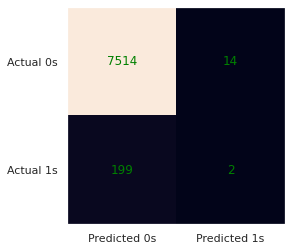

In [53]:
def cm_plot(cm):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='Green')
    plt.show()

cm_plot(cm)

In [ ]:
model_dt.feature_importances_

In [ ]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_dt.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df.sort_values(by = 'importance', ascending =  False).head(60)

## Random forest

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [55]:
model_rf = RandomForestClassifier(n_jobs=-1, random_state = 321)
model_rf.fit(X_train, y_train)
model_rf.score(X_train, y_train)

0.9998706004140787

In [56]:
model_rf.score(X_test, y_test)

0.9736058998576789

In [57]:
train_probs =  model_rf.predict_proba(X_train)
train_probs

array([[1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.44, 0.56]])

In [ ]:
model_rf.estimators_[0]

In [ ]:
len(model_rf.estimators_)

In [ ]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_rf.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df.head(60)

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [58]:
model_rf2 = RandomForestClassifier(n_jobs=-1, random_state = 321, n_estimators = 200, max_depth = 8)
model_rf2.fit(X_train, y_train)
model_rf2.score(X_train, y_train)

0.9753493788819876

In [59]:
model_rf2.score(X_test, y_test)

0.9739940483891836

## XGBOOST

In [60]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

In [61]:
model_xgb = XGBClassifier()

In [62]:
model_xgb = model_xgb.fit(X_train, y_train)

In [63]:
preds = model_xgb.predict(X_test)
accuracy_score(y_test, preds)

0.9737352827015138

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
scores = cross_val_score(model_xgb, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.5f' % mean(scores))

In [ ]:
from collections import Counter
counter = Counter(model_df_def['DEFAULT'])
estimate = counter[0]/counter[1]
estimate

In [74]:
model_xgb2 = XGBClassifier(random_state=321, n_jobs=-1, n_estimators=20, max_depth=20, scale_pos_weight=40)

In [75]:
model_xgb2 = model_xgb2.fit(X_train, y_train)

In [76]:
preds = model_xgb2.predict(X_test)
accuracy_score(y_test, preds)

0.9251272319503149

In [77]:
confusion_matrix(y_test, model_xgb2.predict(X_test))

array([[10677,   616],
       [  252,    48]])

In [78]:
cv2 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [80]:
scores2 = cross_val_score(model_xgb2, X_train, y_train, scoring='roc_auc', cv=cv2, n_jobs=-1)
print('Mean ROC AUC: %.5f' % mean(scores2))

Mean ROC AUC: 0.70360


In [ ]:
from xgboost import XGBRegressor

In [68]:
model_xgb3 = XGBRegressor(random_state=321, n_jobs=-1, n_estimators=20, max_depth=4)

NameError: name 'XGBRegressor' is not defined

In [ ]:
model_xgb3 = model_xgb3.fit(X_train, y_train)

In [ ]:
model_xgb3.score(X_train,y_train)

In [153]:
model_xgb3.score(X_test,y_test)

0.029448074243688893

# Modeling

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.757391 to fit



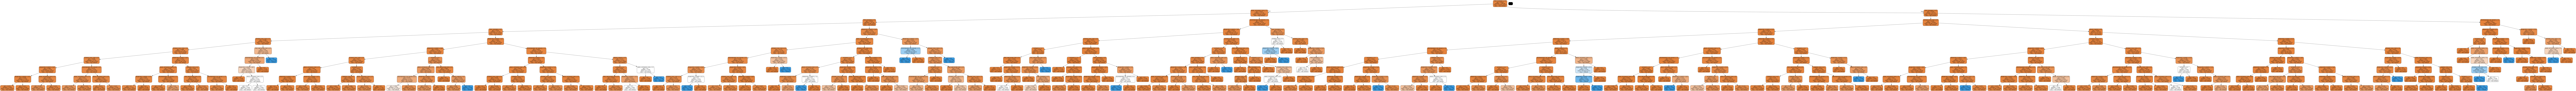

In [81]:
from io import StringIO
from IPython.display import Image, SVG
from graphviz import Source
from sklearn.tree import export_graphviz
import pydotplus

covariates = ['ESTADO_CIVIL_COD', 'TIPO_VIVIENDA', 'MUNICIPIO_CLIENTE', 'TIPO_UBICACION_COD', 'MUJER_CABEZA',
              'RESPONSABLE_DE_HOGAR', 'GENERO_COD', 'ESTRATO', 'NIVEL_ESTUDIOS_COD']
cat_vars= ['ESTADO_CIVIL_COD', 'TIPO_VIVIENDA', 'MUNICIPIO_CLIENTE', 'TIPO_UBICACION_COD', 'MUJER_CABEZA', 
           'RESPONSABLE_DE_HOGAR', 'GENERO_COD', 'ESTRATO', 'NIVEL_ESTUDIOS_COD']

for var in cat_vars:
    model_df[var]=model_df[var].astype('category').cat.codes
    
clf = DecisionTreeClassifier(max_depth = 9)

clf = clf.fit(model_df[covariates], model_df['DEFAULT'])

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, feature_names = covariates,
                class_names=['Non-Default', 'Default'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity='gini', proportion=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [82]:
X_train, X_test, y_train, y_test = train_test_split(model_df[covariates], model_df['DEFAULT'].astype('category').cat.codes,
                                                    test_size=0.25,
                                                    random_state=1)
clf_new = DecisionTreeClassifier(max_depth = 9)
clf_new = clf_new.fit(X_train, y_train)

y_pred_train = clf_new.predict(X_train)
y_pred_test = clf_new.predict(X_test)

print(f"Accuracy in training set: {accuracy_score(y_train, y_pred_train)}")
print(f"Accuracy in the other samples: {accuracy_score(y_test, y_pred_test)}")

Accuracy in training set: 0.9756383712905452
Accuracy in the other samples: 0.9751578511541248


In [83]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, y_train)
    train_acc = 1 - model.score(X_train, y_train)
    val_acc = 1 - model.score(X_test, y_test)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [84]:
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

In [85]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.025397,0.023497
1,2,0.025397,0.023497
2,3,0.025397,0.023497
3,4,0.025397,0.023497
4,5,0.025362,0.023600
5,6,0.025293,0.023704
6,7,0.025190,0.023807
7,8,0.024810,0.024842
8,9,0.024362,0.024739
9,10,0.023844,0.025567


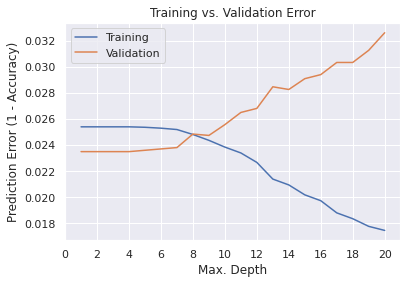

In [86]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

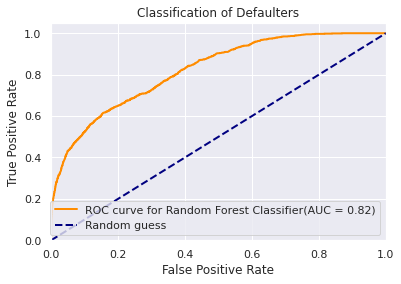

In [87]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=0)
clf_rf.fit(model_df[covariates], model_df['DEFAULT'].astype('category').cat.codes)
clf_rf_probas = clf_rf.predict_proba(model_df[covariates])

roc_p = roc_curve(model_df['DEFAULT'].astype('category').cat.codes, clf_rf_probas[:,1])
auc_p = auc_p = auc( roc_p[0], roc_p[1] )

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width,
         label=f"ROC curve for Random Forest Classifier(AUC = {auc_p:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

In [88]:
X_train, X_test, y_train, y_test = train_test_split(model_df[covariates], model_df['DEFAULT'],
                                                    test_size=0.3,
                                                    random_state=123)
clf_rf_new = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=321)
clf_rf_new = clf_rf_new.fit(model_df[covariates], model_df['DEFAULT'].astype('category').cat.codes)


y_pred_train = clf_rf_new.predict(X_train)
y_pred_test = clf_rf_new.predict(X_test)

print(f"Accuracy in training set: {accuracy_score(y_train, y_pred_train)}")
print(f"Accuracy in the other samples: {accuracy_score(y_test, y_pred_test)}")

Accuracy in training set: 0.9825125702454895
Accuracy in the other samples: 0.9817993616837747


In [89]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_test)

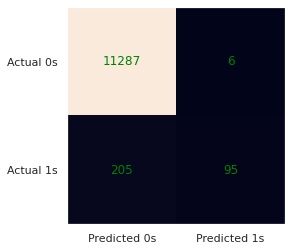

In [90]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='Green')
plt.show()

In [92]:
import joblib
joblib.dump(clf_rf_new, './model')

['./model']

In [ ]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

In [ ]:
model_xgb4 = XGBClassifier(random_state=321, n_jobs=-1, n_estimators=100, max_depth=20, scale_pos_weight=10)

In [ ]:
model_xgb4 = model_xgb4.fit(X_train, y_train)

In [ ]:
preds = model_xgb4.predict(X_test)
accuracy_score(y_test, preds)

0.9359096006210644

In [ ]:
confusion_matrix(y_test, model_xgb4.predict(X_test))

array([[10811,   482],
       [  261,    39]])